In [ ]:
!pip install swig -q
!pip install gymnasium[box2d] -q
!pip install stable-baselines3 -q
!pip install matplotlib -q

In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC, DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode='rgb_array')
n_actions = env.action_space.shape[-1]

In [ ]:
def visualize(model, env, step_limit=1000):
    obs = env.reset()[0]
    img = []
    step_num = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        img.append(env.render())
        step_num += 1
        if terminated or step_num >= step_limit:
            break

    dpi = 72
    interval = 50 # ms
    fig, ax = plt.subplots(figsize=(img[0].shape[1] / dpi, img[0].shape[0] / dpi), dpi=dpi)
    patch = ax.imshow(img[0])
    ax.axis('off')  # Correct usage
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(fig, animate, frames=len(img), interval=interval)
    return HTML(ani.to_jshtml())


def evaluate(model, env, step_limit=1000):
    obs = env.reset()[0]
    total_reward = 0
    step_num = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        step_num += 1
        if terminated or step_num >= step_limit:
            break
    return total_reward / step_num


def train_and_evaluate(model_type, noise_sigma=None, lr=None, total_timesteps=20_000, log_interval=10, device='cuda'):
    if model_type == "DDPG":
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_sigma * np.ones(n_actions))
        model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1, device=device)
    elif model_type == "SAC":
        model = SAC("MlpPolicy", env, verbose=1, learning_rate=lr, device=device)
    model.learn(total_timesteps=total_timesteps, log_interval=log_interval)
    model_name = f"{model_type.lower()}_{noise_sigma if noise_sigma else lr}"
    model.save(model_name)
    print(f"Mean reward for {model_name}: {evaluate(model, env)}")
    return visualize(model, env)

In [ ]:
train_and_evaluate("DDPG", noise_sigma=0.01)

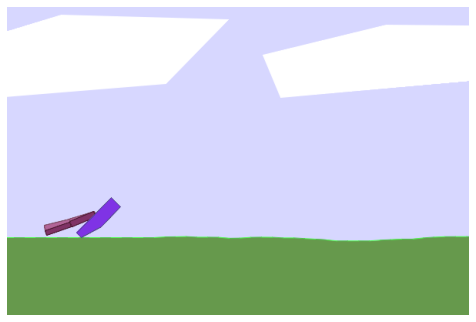

In [ ]:
train_and_evaluate("DDPG", noise_sigma=0.2)

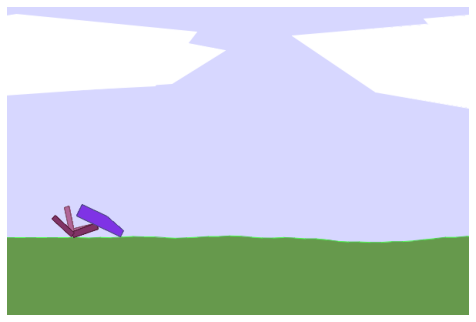

In [ ]:
train_and_evaluate("DDPG", noise_sigma=0.5)

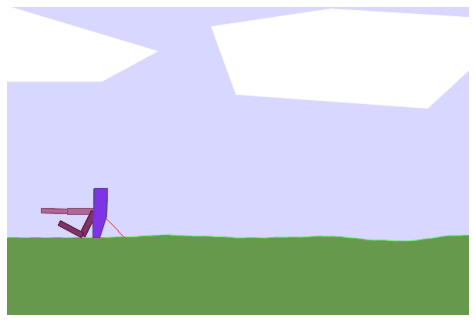

In [ ]:
train_and_evaluate("SAC", lr=5e-5)

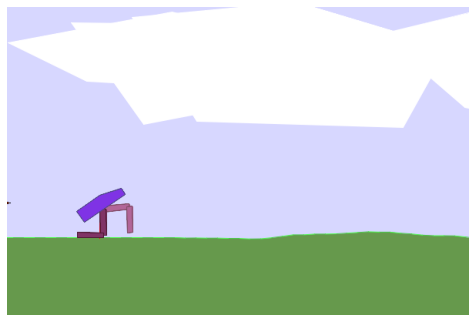

In [ ]:
train_and_evaluate("SAC", lr=2e-4)

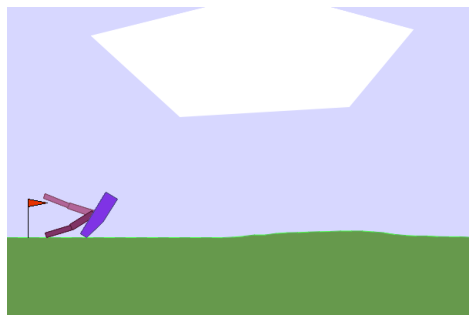

In [ ]:
train_and_evaluate("SAC", lr=1e-3)

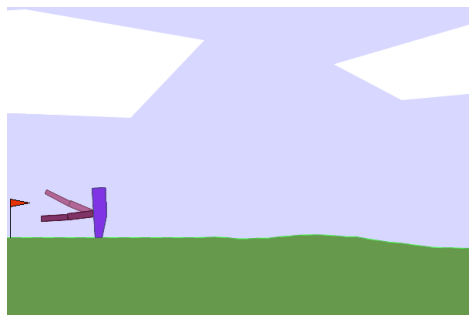

In [ ]:
train_and_evaluate("SAC", lr=5e-5, total_timesteps=50_000)

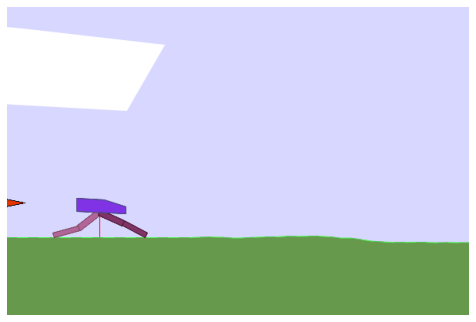